In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install tree
!tree /content/drive/MyDrive/Deep\ Learning\ Project\ Group -L 4

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (87.5 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
/content/drive/MyDrive/Deep Learning Project Group
├── archive
│   ├── CheXpert_Image_EDA.ipynb
│   └── CheXpert_Report_EDA.ipynb
├── CheXClassifier
├── CheXRetriever
│   ├── data
│   │   ├── archive.zip
│   │   ├── metadata.csv
│   │   ├── test
│   │   │   ├── images
│   │   │   ├── te

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import roc_auc_score

from torch.amp import autocast, GradScaler

torch.backends.cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
BASE_DIR = Path("/content/drive/MyDrive/Deep Learning Project Group")
IMAGE_ROOT = BASE_DIR / "CheXRetriever/data"

TRAIN_CSV = IMAGE_ROOT / "train/train_metadata_merged.csv"
VAL_CSV = IMAGE_ROOT / "val/val_metadata_merged.csv"

LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Enlarged Cardiomediastinum",
    "Fracture", "Lung Lesion", "Lung Opacity", "No Finding", "Pleural Effusion",
    "Pleural Other", "Pneumonia", "Pneumothorax", "Support Devices"
]

In [5]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [6]:
def load_split(csv_path, split):
    df = pd.read_csv(csv_path)
    df["split"] = split
    df["filename"] = df["path_to_image"].apply(lambda x: "_".join(x.split("/")).replace(".jpg", ".png"))
    df[LABELS] = df[LABELS].fillna(0).replace(-1, 0)  # Treat uncertain labels as 0
    return df[["filename", "split"] + LABELS]

train_df = load_split(TRAIN_CSV, "train")
val_df = load_split(VAL_CSV, "val")

print("Train size:", train_df.shape)
print("Val size:", val_df.shape)

# For quick testing: limit dataset size
# train_df_small = train_df.sample(n=512, random_state=42).reset_index(drop=True)
# val_df_small = val_df.sample(n=128, random_state=42).reset_index(drop=True)

Train size: (20602, 16)
Val size: (4415, 16)


In [7]:
class CheXpertDataset(Dataset):
    def __init__(self, dataframe, image_root, transform):
        self.df = dataframe.reset_index(drop=True)
        self.image_root = image_root
        self.transform = transform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = self.image_root / row["split"] / "images" / row["filename"]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        labels = torch.tensor(row[LABELS].values.astype(np.float32))
        return image, labels

    def __len__(self):
        return len(self.df)

In [8]:
train_ds = CheXpertDataset(train_df, IMAGE_ROOT, image_transform)
val_ds = CheXpertDataset(val_df, IMAGE_ROOT, image_transform)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

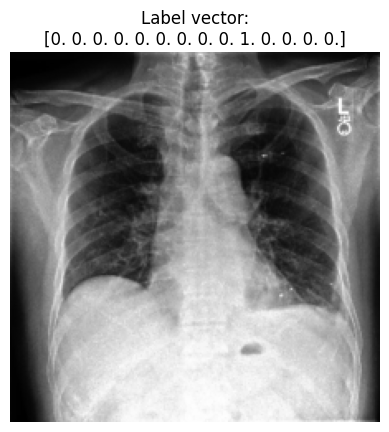

In [9]:
def show_sample(idx=0):
    image, label = train_ds[idx]
    image = image.permute(1, 2, 0)
    image = (image * 0.5) + 0.5

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Label vector:\n{label.numpy()}")
    plt.show()

show_sample(0)

In [10]:
class ResNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        base = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.encoder = nn.Sequential(*list(base.children())[:-1])
        for p in self.encoder.parameters():
            p.requires_grad = False

        self.dropout = nn.Dropout(p=0.3)  # Drop 30% before classification
        self.classifier = nn.Linear(2048, len(LABELS))

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.classifier(x)

In [11]:
model = ResNetClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
scaler = GradScaler()

EPOCHS = 20
best_val_auroc = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for images, targets in loop:
        images, targets = images.to(DEVICE), targets.to(DEVICE)

        with autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_dl)
    print(f"Epoch {epoch+1}: Avg Train Loss = {avg_loss:.4f}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]
Epoch 1/20: 100%|██████████| 322/322 [07:51<00:00,  1.46s/it, loss=0.33]


Epoch 1: Avg Train Loss = 0.3746


Epoch 2/20: 100%|██████████| 322/322 [00:31<00:00, 10.21it/s, loss=0.318]


Epoch 2: Avg Train Loss = 0.3250


Epoch 3/20: 100%|██████████| 322/322 [00:30<00:00, 10.41it/s, loss=0.284]


Epoch 3: Avg Train Loss = 0.3200


Epoch 4/20: 100%|██████████| 322/322 [00:30<00:00, 10.44it/s, loss=0.315]


Epoch 4: Avg Train Loss = 0.3160


Epoch 5/20: 100%|██████████| 322/322 [00:31<00:00, 10.37it/s, loss=0.281]


Epoch 5: Avg Train Loss = 0.3132


Epoch 6/20: 100%|██████████| 322/322 [00:31<00:00, 10.11it/s, loss=0.306]


Epoch 6: Avg Train Loss = 0.3105


Epoch 7/20: 100%|██████████| 322/322 [00:31<00:00, 10.37it/s, loss=0.315]


Epoch 7: Avg Train Loss = 0.3084


Epoch 8/20: 100%|██████████| 322/322 [00:30<00:00, 10.46it/s, loss=0.319]


Epoch 8: Avg Train Loss = 0.3065


Epoch 9/20: 100%|██████████| 322/322 [00:31<00:00, 10.32it/s, loss=0.285]


Epoch 9: Avg Train Loss = 0.3052


Epoch 10/20: 100%|██████████| 322/322 [00:31<00:00, 10.35it/s, loss=0.316]


Epoch 10: Avg Train Loss = 0.3036


Epoch 11/20: 100%|██████████| 322/322 [00:30<00:00, 10.40it/s, loss=0.29]


Epoch 11: Avg Train Loss = 0.3023


Epoch 12/20: 100%|██████████| 322/322 [00:31<00:00, 10.30it/s, loss=0.324]


Epoch 12: Avg Train Loss = 0.3013


Epoch 13/20: 100%|██████████| 322/322 [00:31<00:00, 10.37it/s, loss=0.298]


Epoch 13: Avg Train Loss = 0.3004


Epoch 14/20: 100%|██████████| 322/322 [00:30<00:00, 10.40it/s, loss=0.281]


Epoch 14: Avg Train Loss = 0.2993


Epoch 15/20: 100%|██████████| 322/322 [00:31<00:00, 10.35it/s, loss=0.276]


Epoch 15: Avg Train Loss = 0.2984


Epoch 16/20: 100%|██████████| 322/322 [00:31<00:00, 10.32it/s, loss=0.298]


Epoch 16: Avg Train Loss = 0.2978


Epoch 17/20: 100%|██████████| 322/322 [00:31<00:00, 10.32it/s, loss=0.282]


Epoch 17: Avg Train Loss = 0.2969


Epoch 18/20: 100%|██████████| 322/322 [00:31<00:00, 10.33it/s, loss=0.299]


Epoch 18: Avg Train Loss = 0.2964


Epoch 19/20: 100%|██████████| 322/322 [00:31<00:00, 10.37it/s, loss=0.292]


Epoch 19: Avg Train Loss = 0.2956


Epoch 20/20: 100%|██████████| 322/322 [00:31<00:00, 10.35it/s, loss=0.335]

Epoch 20: Avg Train Loss = 0.2953


In [12]:
def evaluate(model, val_dl):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in val_dl:
            images = images.to(DEVICE)
            outputs = model(images).sigmoid().cpu()
            all_preds.append(outputs)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    aucs = []
    for i, label in enumerate(LABELS):
        try:
            auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
        except:
            auc = float('nan')
        aucs.append(auc)

    mean_auc = np.nanmean(aucs)
    return aucs, mean_auc

In [13]:
aucs, mean_auc = evaluate(model, val_dl)
print(f"Epoch {epoch+1}: Mean AUROC = {mean_auc:.4f}")
for lbl, auc in zip(LABELS, aucs):
    print(f"  {lbl:25s}: AUROC = {auc:.4f}")

if mean_auc > best_val_auroc:
    best_val_auroc = mean_auc
    save_path = BASE_DIR / "resnet_model/best_resnet_classifier.pt"
    torch.save(model.state_dict(), save_path)
    print(f"✅ Saved best model to {save_path}")

Epoch 20: Mean AUROC = 0.6605
  Atelectasis              : AUROC = 0.6560
  Cardiomegaly             : AUROC = 0.7040
  Consolidation            : AUROC = 0.6120
  Edema                    : AUROC = 0.7768
  Enlarged Cardiomediastinum: AUROC = 0.5371
  Fracture                 : AUROC = 0.5584
  Lung Lesion              : AUROC = 0.5804
  Lung Opacity             : AUROC = 0.6611
  No Finding               : AUROC = 0.7523
  Pleural Effusion         : AUROC = 0.7917
  Pleural Other            : AUROC = 0.6328
  Pneumonia                : AUROC = 0.5706
  Pneumothorax             : AUROC = 0.6803
  Support Devices          : AUROC = 0.7328
✅ Saved best model to /content/drive/MyDrive/Deep Learning Project Group/resnet_model/best_resnet_classifier.pt


In [15]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, hamming_loss

def evaluate(model, val_dl):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in val_dl:
            images = images.to(DEVICE)
            outputs = model(images).sigmoid().cpu()
            all_preds.append(outputs)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    pred_bin = (all_preds > 0.5).astype(int)  # Binarized predictions

    aurocs, aps, f1s, precs, recs = [], [], [], [], []
    for i in range(len(LABELS)):
        try:
            aurocs.append(roc_auc_score(all_labels[:, i], all_preds[:, i]))
            aps.append(average_precision_score(all_labels[:, i], all_preds[:, i]))
            f1s.append(f1_score(all_labels[:, i], pred_bin[:, i]))
            precs.append(precision_score(all_labels[:, i], pred_bin[:, i]))
            recs.append(recall_score(all_labels[:, i], pred_bin[:, i]))
        except:
            aurocs.append(np.nan)
            aps.append(np.nan)
            f1s.append(np.nan)
            precs.append(np.nan)
            recs.append(np.nan)

    mean_auc = np.nanmean(aurocs)
    mean_ap = np.nanmean(aps)
    mean_f1 = np.nanmean(f1s)
    mean_precision = np.nanmean(precs)
    mean_recall = np.nanmean(recs)
    hamming = hamming_loss(all_labels, pred_bin)

    return {
        "AUROC": aurocs,
        "mAP": mean_ap,
        "F1": f1s,
        "Precision": precs,
        "Recall": recs,
        "Hamming Loss": hamming,
        "Mean AUROC": mean_auc,
        "Mean F1": mean_f1
    }

metrics = evaluate(model, val_dl)

print(f"\nMean AUROC:     {metrics['Mean AUROC']:.4f}")
print(f"Mean AP (mAP):  {metrics['mAP']:.4f}")
print(f"Mean F1 Score:  {metrics['Mean F1']:.4f}")
print(f"Mean Precision: {np.nanmean(metrics['Precision']):.4f}")
print(f"Mean Recall:    {np.nanmean(metrics['Recall']):.4f}")
print(f"Hamming Loss:   {metrics['Hamming Loss']:.4f}\n")

for lbl, auc, f1 in zip(LABELS, metrics["AUROC"], metrics["F1"]):
    print(f"{lbl:25s}: AUROC={auc:.3f}, F1={f1:.3f}")


Mean AUROC:     0.6605
Mean AP (mAP):  0.2267
Mean F1 Score:  0.0776
Mean Precision: 0.2538
Mean Recall:    0.0497
Hamming Loss:   0.1150

Atelectasis              : AUROC=0.656, F1=0.000
Cardiomegaly             : AUROC=0.704, F1=0.000
Consolidation            : AUROC=0.612, F1=0.000
Edema                    : AUROC=0.777, F1=0.008
Enlarged Cardiomediastinum: AUROC=0.537, F1=0.000
Fracture                 : AUROC=0.558, F1=0.000
Lung Lesion              : AUROC=0.580, F1=0.000
Lung Opacity             : AUROC=0.661, F1=0.242
No Finding               : AUROC=0.752, F1=0.178
Pleural Effusion         : AUROC=0.792, F1=0.354
Pleural Other            : AUROC=0.633, F1=0.000
Pneumonia                : AUROC=0.571, F1=0.000
Pneumothorax             : AUROC=0.680, F1=0.000
Support Devices          : AUROC=0.733, F1=0.304


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p